In [3]:
# @title Imported Libraries
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
import matplotlib.pyplot as plt
import altair as alt

In [7]:
# @title Snapshot of Data Head
mortalidad = pd.read_excel('/MORT-CAMAmer.xlsx')
mortalidad.head()

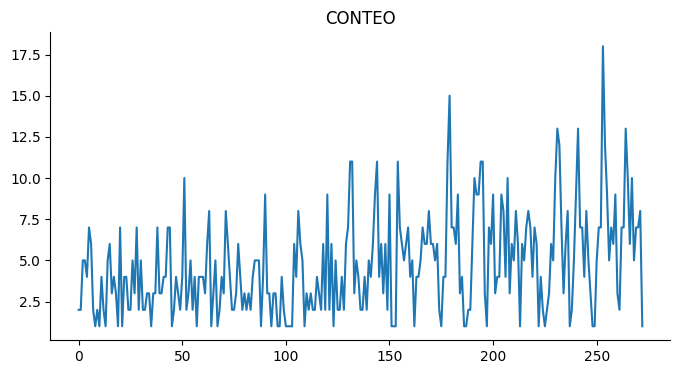

In [ ]:
# @title CONTEO

from matplotlib import pyplot as plt
mortalidad['CONTEO'].plot(kind='line', figsize=(8, 4), title='CONTEO')
plt.gca().spines[['top', 'right']].set_visible(False)

<h2>Display data frame entries:<h2>

- ```ENT_CVE```: State Code (from INEGI) that uniquely identifies each state in Mexico. Useful for joining with geographic shapefiles or other datasets for state-level analysis.


- ```ENT_NOMBRE```: State Name

- ```CVE_MUN```: Municipality Code (from INEGI) that uniquely identifies municipalities within each state. Enables sub-state geographic analysis and facilitates localization of high-mortality areas.

- ```NOM_MUN```: Municipality Name

- ```AÑO```: Year of the recorded mortality event.

- ```gpoEdad```: Age range of the deceased (e.g., "30_34").

- ```SEXO```: Sex of the deceased (e.g., "Mujeres").

- ```CAUSA_D```: ICD-10 Cause of Death Code (e.g., "C50" = malignant neoplasm of breast).

- ```CONTEO```: Count of Deaths (count in that row’s combination of state, municipality, year, age group, sex, and cause.)

In [ ]:
# @title Annual Behavior

alt.data_transformers.disable_max_rows()

# Precompute ticks every 5 years
years = sorted(mortalidad["AÑO"].unique().tolist())
labelingX = [int(y) for y in years if int(y) % 2 == 0]

# 📈 Chart
chart = alt.Chart(mortalidad).mark_line(point=True).encode(
    x=alt.X("AÑO:O", axis=alt.Axis(title="Año", values=labelingX)),
    y=alt.Y("sum(CONTEO):Q", title="Defunciones"),
    tooltip=[alt.Tooltip("AÑO:O", title="Año"),
             alt.Tooltip("sum(CONTEO):Q", title="Defunciones (Total)", format=",")]
).properties(
    width=650, height=360, title="Defunciones por Año"
)

chart

alt.Chart(...)

In [ ]:
def _age_sort_key(label: str):
    try:
        return int(label.split("_")[0])
    except:
        return 10_000  # shove unknowns to the end
age_order = sorted(mortalidad["gpoEdad"].unique(), key=_age_sort_key)
mortalidad["gpoEdad"] = pd.Categorical(mortalidad["gpoEdad"], categories=age_order, ordered=True)

In [ ]:
# @title Deaths by Year by Age Groups

alt.data_transformers.disable_max_rows()

base = alt.Chart(mortalidad).mark_bar().encode(
    x=alt.X("AÑO:O",
            title="Año",
            axis=alt.Axis(
            values=[y for y in sorted(mortalidad["AÑO"].unique()) if y % 5 == 0]
    )),
    y=alt.Y("sum(CONTEO):Q",
            title="Defunciones (suma)",
            scale=alt.Scale(domain=[0, 20])
    ),

    tooltip=[
        alt.Tooltip("gpoEdad:N", title="Grupo de edad"),
        alt.Tooltip("AÑO:O", title="Año"),
        alt.Tooltip("sum(CONTEO):Q", title="Defunciones", format=",")
    ]
).properties(
    width=120,
    height=120
)


chart = base.facet(
    facet=alt.Facet("gpoEdad:N", title="Grupo de edad"),
    columns=4
).resolve_scale(
    y='independent'  # each facet gets its own y-scale (clearer comparisons within facet)
).properties(
    title="Defunciones por Año (Facetadas por Grupo de Edad)"
).configure_axis(
    labelFontSize=11,
    titleFontSize=12
).configure_header(
    labelFontSize=12,
    titleFontSize=14
)

chart

alt.FacetChart(...)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# @title Total Death Count by Age Group

age_totals = mortalidad.groupby("gpoEdad", as_index=False)["CONTEO"].sum().sort_values("CONTEO", ascending=False)
age_totals["cum_pct"] = age_totals["CONTEO"].cumsum() / age_totals["CONTEO"].sum()

bar = alt.Chart(age_totals).mark_bar().encode(
    x=alt.X("gpoEdad:N", sort="-y"),
    y="CONTEO:Q",
    tooltip=["gpoEdad:N", "CONTEO:Q"]
)

line = alt.Chart(age_totals).mark_line(color="red").encode(
    x=alt.X("gpoEdad:N",title="Edades"),
    y=alt.Y("cum_pct:Q", title="Total Defunciones")
)

(bar + line).properties(title="Muertes por Grupo de Edad")

alt.LayerChart(...)

In [ ]:
# @title Variation within Age Groups

alt.Chart(mortalidad).mark_boxplot().encode(
    x=alt.X("gpoEdad:N", title="Edades"),
    y=alt.Y("CONTEO:Q", title="Defunciones", scale=alt.Scale(domain=[0,20])),
    tooltip=["gpoEdad:N", "CONTEO:Q"]
).properties(title="Variabilidad Anual de Muertes por Grupo")


alt.Chart(...)